In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import astropy.units as u

In [2]:
mp.rcParams['figure.figsize'] = (12, 8)

In [3]:
from context import lens

In [4]:
from lens.sie.inferencePM import *

In [5]:
import emcee

# A simple Baysian model


## source parameters $\theta_{src}$
* $g_{S}$
* $x_{S}$
* $y_{S}$
* $dx_{S}$
* $dy_{S}$

## SIE lens parameters $\theta_{SIE}$
* $b_L$ : Einstein's radius 
* $q_L$ : axis ratio
* $x_L$
* $y_L$
* $\theta_L$ : orientation

# Priors
see lens.sie.inference

Text(0.5,0,'Magnitude radius prior')

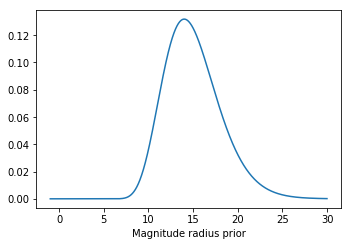

In [5]:
plt.subplot(221)
x = np.arange(-1,30,0.01)
y = [magnitudePrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Magnitude radius prior")

Text(0.5,0,'Lens orientation prior')

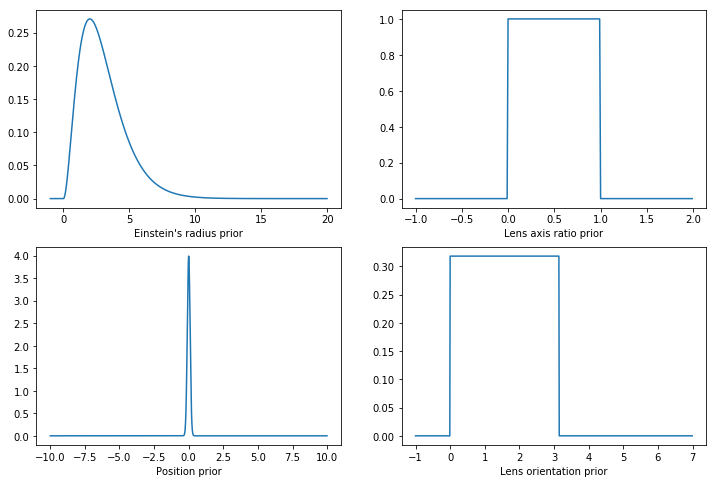

In [6]:
plt.subplot(221)
x = np.arange(-1,20,0.01)
y = [radiusPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Einstein's radius prior")

plt.subplot(222)
x = np.arange(-1,2,0.01)
y = [ratioPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Lens axis ratio prior")

plt.subplot(223)
x = np.arange(-10,10,0.01)
y = [positionPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Position prior")

plt.subplot(224)
x = np.arange(-1,7,0.01)
y = [thetaPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Lens orientation prior")

# An example

In [7]:
model = np.array([0.1,0.1,0.5,0.5,18,2,0.5,0,0,0.])
parameter = "xs,ys,dxs,dys,gs,b,q,xl,yl,theta".split(',')

In [8]:
log_prior_pm(model)

-0.905878545247079

generate a fake data based on the model

In [9]:
errors = np.concatenate((np.ones((4,2))*0.001,(np.ones((4,2))),(np.ones((4,1))*0.01)),axis=1)

In [10]:
data = np.concatenate((np.array(getImages_pm(model)),errors),axis=1)

In [11]:
data

array([[ 2.31859302e+00,  4.99525670e-01,  4.03044227e-01,
         9.50028881e-01,  1.71437125e+01,  1.00000000e-03,
         1.00000000e-03,  1.00000000e+00,  1.00000000e+00,
         1.00000000e-02],
       [-4.33458667e-01,  1.83727673e+00, -3.90554158e-01,
         2.89896420e-01,  1.87072242e+01,  1.00000000e-03,
         1.00000000e-03,  1.00000000e+00,  1.00000000e+00,
         1.00000000e-02],
       [-1.85067609e+00,  7.24527639e-01,  1.01001431e+00,
         1.80274020e+00,  1.67509826e+01,  1.00000000e-03,
         1.00000000e-03,  1.00000000e+00,  1.00000000e+00,
         1.00000000e-02],
       [-2.29748630e-01, -1.47703465e+00, -3.74904859e-03,
         5.78356763e-01,  1.96343889e+01,  1.00000000e-03,
         1.00000000e-03,  1.00000000e+00,  1.00000000e+00,
         1.00000000e-02]])

In [12]:
log_likelihood_pm(model,data)

24.018201316418846

In [13]:
log_posterior_pm(model,data)

array(23.11232277)

define sampler parameters

In [14]:
ndim = len(model)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 1000  # number of MCMC steps

use starting value that are compatiple with the lens fit withour propermotion, one should also change the prior

In [15]:
np.random.seed(0)
def init(N):
    """ set each walkers initial values randomly around guessed values"""
    xs = norm.rvs(0.1,0.01,size=N)
    ys = norm.rvs(0.1,0.01,size=N)
    dxs = norm.rvs(0,0.2,size=N)
    dys = norm.rvs(0,0.2,size=N)
    gs = norm.rvs(18,0.1,size=N)
    xl = norm.rvs(0,0.1,size=N)
    yl = norm.rvs(0,0.1,size=N)
    b = norm.rvs(2,0.1,size=N) #beta.rvs(2,3,size=N)
    q = norm.rvs(0.5,0.01,N)
    theta = np.random.uniform(0,np.pi,N)
    return np.transpose(np.array([xs,ys,dxs,dys,gs,b,q,xl,yl,theta]))

In [16]:
starting_guesses = init(nwalkers)

check that the initial values make sens with respect to the prior

In [17]:
np.std([log_prior_pm(guess) for guess in starting_guesses])

0.4459271293298221

In [18]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_pm, args=[data])
%time x = sampler.run_mcmc(starting_guesses, nsteps)

/Users/abombrun/IPythonNB/Projects/Preparation4Stat/lens/sie/inferencePM.py:13: RuntimeWarning: divide by zero encountered in log10
  res = res + np.log10(radiusPrior(b)) + np.log10(ratioPrior(q)) + np.log10(thetaPrior(theta))


CPU times: user 2min 3s, sys: 562 ms, total: 2min 4s
Wall time: 2min 4s


with a prior on theta that does not restrict the lens orientation, i.e. multi modal distribution in theta, emcee sampling does not seem to behave very well!

moreover one should choose carefully the initial range value

In [19]:
def plot_chains(sampler,warmup=400):
    fig, ax = plt.subplots(ndim,3, figsize=(12, 12))
    samples = sampler.chain[:, warmup:, :].reshape((-1, ndim))
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i,0].vlines(warmup,np.min(sampler.chain[:, :, i].T),np.max(sampler.chain[:, :, i].T),'r')
        ax[i,1].hist(samples[:,i],bins=100,label=parameter[i]);
        ax[i,1].legend()
        ax[i,1].vlines(np.median(samples[:,i]),0,10000,lw=1,color='r',label="median")
        ax[i,1].vlines(np.median(model[i]),0,5000,lw=1,color='b',label="true")
        ax[i,2].hexbin(samples[:,i],samples[:,(i+1)%ndim])#,s=1,alpha=0.1);

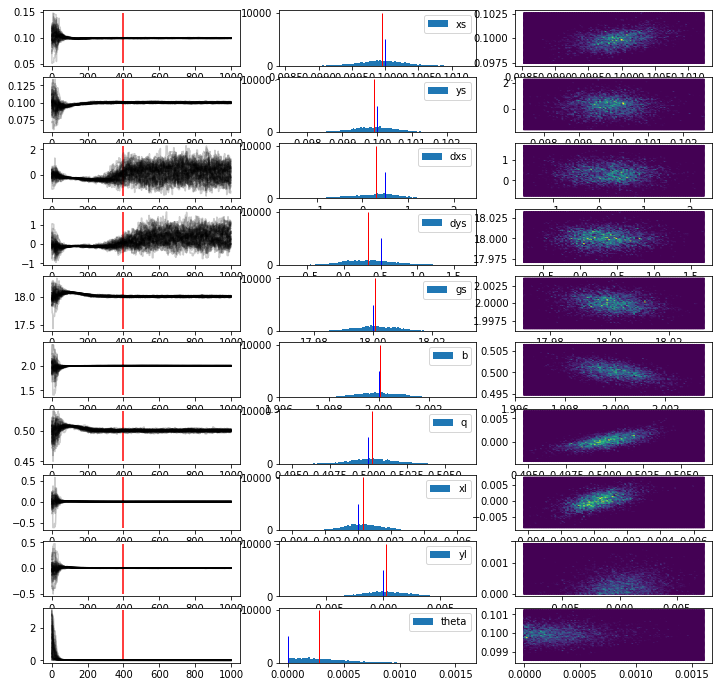

In [20]:
plot_chains(sampler)